In [1]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import os
import json
import pprint
import scipy.stats as stats
import urllib
from urllib.parse import quote
import re

# # Used for census.gov data
# from census import Census

# Census API Key
from config import census_key
from config import yelp_key

# c = Census(census_key, year=2013)

In [2]:
#File with ZIP Code data
file = 'input/zipcodes_nyc.csv'

# Read all ZIP codes with their Latitude and Longitude for the St. Louis City and St. Louis County area
# When testing use a small set of ZIP Codes: df_zip = df.iloc[0:5,:]
df_zip = pd.read_csv(file)

zip_count = df_zip.zip_code.count()
print(f"Total zip codes: {zip_count}")
df_zip.head()

Total zip codes: 176


,zip_code,county,latitude,longetude
0,10453,Bronx,40.853017,-73.91214
1,10458,Bronx,40.864166,-73.88881
2,10451,Bronx,40.819729,-73.92230
3,10454,Bronx,40.805968,-73.91628
4,10463,Bronx,40.881086,-73.90749


In [3]:
# Get ready to import yelp data
API_KEY=yelp_key

API_HOST = 'https://api.yelp.com'
SEARCH_PATH = '/v3/businesses/search'
MATCH_PATH = '/v3/businesses/matches'
SEARCH_PHONE_PATH = '/v3/businesses/search/phone'
BUSINESS_PATH = '/v3/businesses/'  # Business ID will come after slash

In [4]:
def request(host, path, api_key, url_params=None):
    url_params = url_params or {}
    url = '{0}{1}'.format(host, quote(path.encode('utf8')))
    headers = {
        'Authorization': 'Bearer %s' % api_key,
    }
#     print(u'Querying {0} ...'.format(url))
#     print(headers)

    response = requests.request('GET', url, headers=headers, params=url_params)
    return response.json() #, my_url

In [5]:
df_businesses = pd.DataFrame()
df_bus_total = pd.DataFrame()
prices = []
dict_total = {}

for index, row in df_zip.iterrows():
    row_zip = row[0]
    row_city = row[1]
    row_lat = row[2]
    row_long = row[3]
    #     print(index, row_zip, row_lat, row_long)
    url_params={"city":row_city, 'zip_code':row_zip,'latitude':row_lat,'longitude':row_long}
    dict_businesses = request(API_HOST, SEARCH_PATH, API_KEY, url_params)

    df_businesses['business_id']=[business["id"] for business in dict_businesses['businesses']]
    df_businesses['name']=[business["name"]for business in dict_businesses['businesses']]
    df_businesses['rating']=[business["rating"]for business in dict_businesses['businesses']]
    df_businesses['zip_code']=[business['location']["zip_code"]for business in dict_businesses['businesses']]
    df_businesses['review_count']=[business["review_count"]for business in dict_businesses['businesses']]

    for b in dict_businesses['businesses']:
        try:
            my_price = b['price']
            prices.append(my_price)
        except:
            prices.append('*')
    
#     dict_total.update(dict_businesses)
    
    df_bus_total = df_bus_total.append(df_businesses)

df_bus_total.head()

,business_id,name,rating,zip_code,review_count
0,6BnU1pAeE2Urlx3x4ANigQ,The Cloisters,4.5,10040,627
1,b6jOwyX4iaagw8YjXqq1sA,Antonio's Trattoria,4.5,10458,758
2,LYs2lYFLSqu_j_ogONphRw,Fort Tryon Park,5.0,10040,221
3,tLZfepIfSf0a80zHQTbTGQ,Trattoria Zero Otto Nove,4.0,10458,737
4,Dwg-RgHUXsBfAi7G0V8LIg,Green Juice Cafe,5.0,10033,191


In [6]:
# Add prices info and cleanup
df_bus_total['price'] = prices
df_bus_total = df_bus_total.loc[(df_bus_total['price'] != '*')]
bus_count = df_bus_total.business_id.count()
print(f"Total businesses: {bus_count}")
# df_bus_total.head()

df_bus_total.head()

Total businesses: 3296


,business_id,name,rating,zip_code,review_count,price
1,b6jOwyX4iaagw8YjXqq1sA,Antonio's Trattoria,4.5,10458,758,$$
3,tLZfepIfSf0a80zHQTbTGQ,Trattoria Zero Otto Nove,4.0,10458,737,$$
4,Dwg-RgHUXsBfAi7G0V8LIg,Green Juice Cafe,5.0,10033,191,$
5,HVeQNs_7zh3m-xCZ1ugslA,Beans and Vines,4.5,10034,410,$$
6,2IrwjU67gguqLqQqZ1nFPg,Guadalupe Restaurant,4.0,10034,645,$$


In [7]:
# Specify the file to write to
output_path = os.path.join("output", "business_data_nyc.csv")
df_bus_total.to_csv(output_path)

In [8]:
# Drop duplicates
df_bus_total = df_bus_total.sort_values('business_id')
df_bus_total = df_bus_total.reset_index(drop=True)
df_bus_unique = df_bus_total.drop_duplicates(['business_id'], keep='first')

In [9]:
bus_uni_count = df_bus_unique.business_id.count()
print(f"Total unique businesses: {bus_uni_count}")
df_bus_unique.head()
# Optionally use a smaller data set: df_bus_unique_small = df_bus_unique[1:5]

Total unique businesses: 1269


,business_id,name,rating,zip_code,review_count,price
0,-8HsKILlFcC8ieznte56eg,Lulu's Bakery,4.0,11366,347,$$
6,-9NO2IDCJMyNGZMAQ1-VQw,NY Pizza Suprema,4.0,10001,1940,$
8,-BmS1FH3DSK6fSifIt8GgQ,Nurnberger Bierhaus,4.0,10310,207,$$
11,-NglVrPdjl3dG-z8ZBzJyQ,The Wilky,4.5,11221,149,$$
13,-OixbLnFLCzQclxCSbUQ8w,Up Thai,4.5,10021,2176,$$


In [10]:
# Specify the file to write to
output_path = os.path.join("output", "business_unique_data_nyc.csv")
df_bus_unique.to_csv(output_path)

In [12]:
# Get reviews for each unique business
dict_rev_total = {}
dict_reviews = {}
df_reviews = pd.DataFrame()
df_rev_total = pd.DataFrame()

for index, row in df_bus_unique.iterrows():
    row_bus = row[0]
#     print(row_bus)
    REVIEW_PATH = BUSINESS_PATH + row_bus + '/reviews'
    dict_reviews = request(API_HOST, REVIEW_PATH, API_KEY)
#     pprint.pprint(dict_reviews)
    try:
        df_reviews['business_id']= [row_bus for review in dict_reviews['reviews']]
        df_reviews['review_id']=[review["id"]for review in dict_reviews['reviews']]
        df_reviews['rating']=[review["rating"]for review in dict_reviews['reviews']]
        df_reviews['name']=[review['user']["name"]for review in dict_reviews['reviews']]
        df_rev_total = df_rev_total.append(df_reviews)
    except:
        pass

In [13]:
rev_uni_count = df_rev_total.review_id.count()
print(f"Total reviews: {rev_uni_count}")
df_rev_total.head()

Total reviews: 3804


,business_id,review_id,rating,name
0,-8HsKILlFcC8ieznte56eg,EYnuAcdV2-XBzGmNwl0PRg,5,Jen B.
1,-8HsKILlFcC8ieznte56eg,wNWHeIHL5pCMaAk42kiZNA,5,Mickel E.
2,-8HsKILlFcC8ieznte56eg,6rlfZe4waTotfKSa5nlRHA,3,Kathryn K.
0,-9NO2IDCJMyNGZMAQ1-VQw,qOuCGXJ4gjTCYnmcpSYd4g,5,Jules D.
1,-9NO2IDCJMyNGZMAQ1-VQw,5FGbIIe7K9uSmJQp5XfXMg,4,Kat B.


In [14]:
#COMMENT OUT THE RESET BELOW IF RAN MULTIPLE TIMES!!!!

df_rev_total.reset_index(inplace=True)

# create a list with names per review and take only the name before the 'space' as a first name
df_rev_total['short name']=""
short_name = []
for index, row in df_rev_total.iterrows():
#     print(row)
    short_name = re.split("( )",row[4])
#     print(short_name)
    df_rev_total.iloc[index, 5] = short_name[0].lower()

In [15]:
rev_uni_count = df_rev_total.review_id.count()
print(f"Total reviews: {rev_uni_count}")
df_rev_total.head()

Total reviews: 3804


,index,business_id,review_id,rating,name,short name
0,0,-8HsKILlFcC8ieznte56eg,EYnuAcdV2-XBzGmNwl0PRg,5,Jen B.,jen
1,1,-8HsKILlFcC8ieznte56eg,wNWHeIHL5pCMaAk42kiZNA,5,Mickel E.,mickel
2,2,-8HsKILlFcC8ieznte56eg,6rlfZe4waTotfKSa5nlRHA,3,Kathryn K.,kathryn
3,0,-9NO2IDCJMyNGZMAQ1-VQw,qOuCGXJ4gjTCYnmcpSYd4g,5,Jules D.,jules
4,1,-9NO2IDCJMyNGZMAQ1-VQw,5FGbIIe7K9uSmJQp5XfXMg,4,Kat B.,kat


In [16]:
file = 'input/gender names.csv'
df = pd.read_csv(file)
df = df.set_index('first_name')
df.head()

,nameprimary,gender,count
first_name,,,
aa,AA,Not Known,1
aabha,AABHA,Female,1
aabida,AABIDA,Female,1
aad,AAD,Male,1
aadarsh,AADARSH,Male,1


In [17]:
df_rev_total['gender']=""
gender = []
for index, row in df_rev_total.iterrows():
    try:
        gender = df.loc[str(row[5]),'gender']
    #     print(gender)
        df_rev_total.iloc[index, 6] = gender
    except:
        pass
df_rev_total.head()

# Drop reviews with where gender isn't found
df_rev_total = df_rev_total.loc[(df_rev_total['gender']!="") & (df_rev_total['gender']!="Both") & (df_rev_total['gender']!="Not Known")]

In [18]:
# Specify the file to write to
df_rev_total = df_rev_total.rename(columns={'rating':'reviewer_rating', 'name':'reviewer_full'})
output_path = os.path.join("output", "review_by_gender_data_nyc.csv")
df_rev_total.to_csv(output_path)

rev_gender_count = df_rev_total.review_id.count()
print(f"Total reviews with gender: {rev_gender_count}")

# Specify the file to write to
output_path = os.path.join("output", "review_data_nyc.csv")
df_rev_total.to_csv(output_path)

df_rev_total.head()

Total reviews with gender: 2992


,index,business_id,review_id,reviewer_rating,reviewer_full,short name,gender
0,0,-8HsKILlFcC8ieznte56eg,EYnuAcdV2-XBzGmNwl0PRg,5,Jen B.,jen,Female
1,1,-8HsKILlFcC8ieznte56eg,wNWHeIHL5pCMaAk42kiZNA,5,Mickel E.,mickel,Male
2,2,-8HsKILlFcC8ieznte56eg,6rlfZe4waTotfKSa5nlRHA,3,Kathryn K.,kathryn,Female
4,1,-9NO2IDCJMyNGZMAQ1-VQw,5FGbIIe7K9uSmJQp5XfXMg,4,Kat B.,kat,Female
5,2,-9NO2IDCJMyNGZMAQ1-VQw,NoGmKRYEwOl_LqVXkMVA0Q,4,Kelly H.,kelly,Female


In [19]:
df_total = pd.merge(df_rev_total, df_bus_total,on=('business_id'))
# Somehow renaming columns duplicated rows
df_total = df_total.drop_duplicates()
# df_total.count()

In [21]:
# Specify the file to write to
output_path = os.path.join("output", "total_everything_nyc.csv")
df_total.to_csv(output_path)

total_count = df_total.review_id.count()
print(f"Total reviews: {total_count}")
df_total.head()
print(df_total['gender'].value_counts())

Total reviews: 2995
Female    1853
Male      1142
Name: gender, dtype: int64


In [22]:
df_total['price_num'] = df_total['price']
df_total['price_num'] = df_total['price_num'].replace(
    {'$':1,'$$':2,'$$$':3,'$$$$':4})

df_total

,index,business_id,review_id,reviewer_rating,reviewer_full,short name,gender,name,rating,zip_code,review_count,price,price_num
0,0,-8HsKILlFcC8ieznte56eg,EYnuAcdV2-XBzGmNwl0PRg,5,Jen B.,jen,Female,Lulu's Bakery,4.0,11366,347,$$,2
6,1,-8HsKILlFcC8ieznte56eg,wNWHeIHL5pCMaAk42kiZNA,5,Mickel E.,mickel,Male,Lulu's Bakery,4.0,11366,347,$$,2
12,2,-8HsKILlFcC8ieznte56eg,6rlfZe4waTotfKSa5nlRHA,3,Kathryn K.,kathryn,Female,Lulu's Bakery,4.0,11366,347,$$,2
18,1,-9NO2IDCJMyNGZMAQ1-VQw,5FGbIIe7K9uSmJQp5XfXMg,4,Kat B.,kat,Female,NY Pizza Suprema,4.0,10001,1940,$,1
20,2,-9NO2IDCJMyNGZMAQ1-VQw,NoGmKRYEwOl_LqVXkMVA0Q,4,Kelly H.,kelly,Female,NY Pizza Suprema,4.0,10001,1940,$,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7722,0,zo4JHfD2nWPUiqgsgDOaHQ,Naz7zM_8WKcPhs8HK65HWg,5,John S.,john,Male,Rao's,4.5,10029,146,$$$$,4
7724,1,zo4JHfD2nWPUiqgsgDOaHQ,TwnPWmGys8sENSATCjujNw,5,Matt L.,matt,Male,Rao's,4.5,10029,146,$$$$,4
7726,2,zo4JHfD2nWPUiqgsgDOaHQ,QQPfiwGUZWt9ttAJblKF2g,5,Eliseo G.,eliseo,Male,Rao's,4.5,10029,146,$$$$,4
7728,0,zxNvP9A5gqJWg_2xQ8s43w,Nu_s_AGn0yciWA_LbvbC1w,5,Shelley L.,shelley,Female,Pizza Classica,4.0,11385,389,$$,2


In [ ]:
# df_zip = df_zip.rename(columns={'ZIP Code':'zip_code'})
# df_total['zip_code'] = pd.to_numeric(df_total['zip_code'])
# df_total_zip = pd.merge(df_total, df_zip, on='zip_code', how='outer')
# df_total_zip.head()

In [23]:
# Specify the file to write to
output_path = os.path.join("output", "total_everything_nyc.csv")
df_total.to_csv(output_path)

Female    1853
Male      1142
Name: gender, dtype: int64


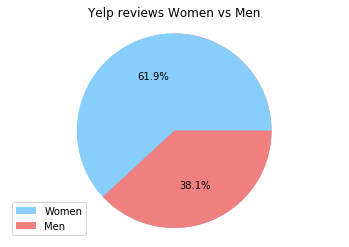

In [24]:
total_reviews = df_total['gender'].value_counts()

plt.clf()
colors = ['lightskyblue', 'lightcoral']
labels = ['Women','Men']
patches, texts = plt.pie(total_reviews, colors=colors, startangle=90)
plt.legend(patches, labels, loc="best")
plt.pie(total_reviews, colors=colors, autopct="%1.1f%%")
plt.axis('equal')
# plt.tight_layout()
plt.title("Yelp reviews Women vs Men")
plt.savefig("Images/Women_vw_Men_nyc.png")

print(total_reviews)


,index,business_id,review_id,reviewer_rating,reviewer_full,short name,gender,name,rating,zip_code,review_count,price,price_num
0,0,-8HsKILlFcC8ieznte56eg,EYnuAcdV2-XBzGmNwl0PRg,5,Jen B.,jen,Female,Lulu's Bakery,4.0,11366,347,$$,2
6,1,-8HsKILlFcC8ieznte56eg,wNWHeIHL5pCMaAk42kiZNA,5,Mickel E.,mickel,Male,Lulu's Bakery,4.0,11366,347,$$,2
12,2,-8HsKILlFcC8ieznte56eg,6rlfZe4waTotfKSa5nlRHA,3,Kathryn K.,kathryn,Female,Lulu's Bakery,4.0,11366,347,$$,2
18,1,-9NO2IDCJMyNGZMAQ1-VQw,5FGbIIe7K9uSmJQp5XfXMg,4,Kat B.,kat,Female,NY Pizza Suprema,4.0,10001,1940,$,1
20,2,-9NO2IDCJMyNGZMAQ1-VQw,NoGmKRYEwOl_LqVXkMVA0Q,4,Kelly H.,kelly,Female,NY Pizza Suprema,4.0,10001,1940,$,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7722,0,zo4JHfD2nWPUiqgsgDOaHQ,Naz7zM_8WKcPhs8HK65HWg,5,John S.,john,Male,Rao's,4.5,10029,146,$$$$,4
7724,1,zo4JHfD2nWPUiqgsgDOaHQ,TwnPWmGys8sENSATCjujNw,5,Matt L.,matt,Male,Rao's,4.5,10029,146,$$$$,4
7726,2,zo4JHfD2nWPUiqgsgDOaHQ,QQPfiwGUZWt9ttAJblKF2g,5,Eliseo G.,eliseo,Male,Rao's,4.5,10029,146,$$$$,4
7728,0,zxNvP9A5gqJWg_2xQ8s43w,Nu_s_AGn0yciWA_LbvbC1w,5,Shelley L.,shelley,Female,Pizza Classica,4.0,11385,389,$$,2


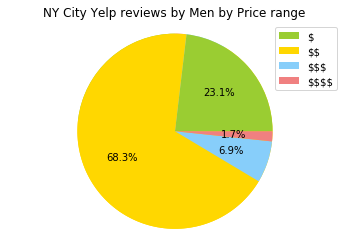

In [25]:
# use line below to bypass API calls
# df_total = pd.read_csv('output/total_everything_nyc.csv')

men_sizes = []
df_only_men = df_total.loc[(df_total["gender"] == 'Male')]

df_only_men_price_count = df_only_men.loc[(df_only_men["price"] != '*')]
# df_only_men_price_count = df_only_men.loc[(df_only_men["reviewer_rating"] != '*')]

df_only_men_price_count_gb = df_only_men_price_count.groupby(['price'])
# df_only_men_price_count_gb = df_only_men_price_count.groupby(['reviewer_rating'])

men_sizes = df_only_men_price_count_gb['price'].count()
# men_sizes = df_only_men_price_count_gb['reviewer_rating'].count()

# avg_rating_men = df_only_men_price_count['reviewer_rating'].mean()
# print(avg_rating_men)

plt.clf()
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
labels = ['\$','\$\$','\$\$\$','\$\$\$\$']

patches, texts = plt.pie(men_sizes, colors=colors, startangle=90)
plt.legend(patches, labels, loc="best")
plt.pie(men_sizes, colors=colors, autopct="%1.1f%%")
plt.axis('equal')
# plt.tight_layout()
plt.title("NY City Yelp reviews by Men by Price range")
plt.savefig("Images/Men_Price_Reviews_nyc.png")
# df_only_men_price_count['reviewer_rating'].value_counts()
men_sizes
df_total

4.117377226119806


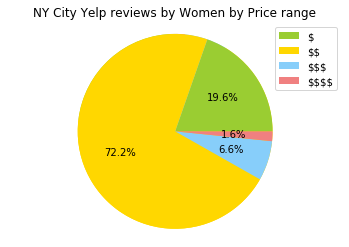

price
$        364
$$      1337
$$$      122
$$$$      30
Name: price, dtype: int64

In [26]:
women_sizes = []
df_only_women = df_total.loc[(df_total["gender"] == 'Female')]

df_only_women_price_count = df_only_women.loc[(df_only_women["price"] != '*')]
# df_only_women_price_count = df_only_women.loc[(df_only_women["reviewer_rating"] != '*')]

df_only_women_price_count_gb = df_only_women_price_count.groupby(['price'])
# df_only_women_price_count_gb = df_only_women_price_count.groupby(['reviewer_rating'])

women_sizes = df_only_women_price_count_gb['price'].count()
# women_sizes = df_only_women_price_count_gb['reviewer_rating'].count()

avg_rating_women = df_only_women_price_count['rating'].mean()
print(avg_rating_women)

plt.clf()
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
labels = ['\$','\$\$','\$\$\$','\$\$\$\$']
patches, texts = plt.pie(men_sizes, colors=colors, startangle=90)
plt.legend(patches, labels, loc="best")
plt.pie(women_sizes, colors=colors, autopct="%1.1f%%")
plt.axis('equal')
# plt.tight_layout()
plt.title("NY City Yelp reviews by Women by Price range")
plt.savefig("Images/Women_Price_Reviews_nye.png")
plt.show()
women_sizes

gender           Female  Male
reviewer_rating              
1                    62    86
2                    63    61
3                   121   129
4                   307   275
5                   589   591


<Figure size 432x288 with 0 Axes>

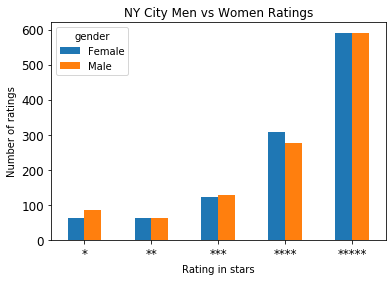

In [27]:
df_total_male = df_total.loc[df_total['gender']=='Male']
df_total_female = df_total.loc[df_total['gender']=='Female']

max_men = df_total_male['reviewer_rating'].count()
df_total_female = df_total_female.iloc[0:max_men,:]

df_total_m_f = df_total_male
df_total_m_f = df_total_m_f.append(df_total_female)

df_summary_reviews_gb = df_total_m_f.groupby(['reviewer_rating','gender'])
df_summary_reviews = pd.DataFrame(df_summary_reviews_gb['review_id'].count())
df_summary_pivot = df_summary_reviews.pivot_table('review_id','reviewer_rating','gender')
df_summary_pivot

plt.clf()

x_axis = ['*','**','***','****','*****']
# x_axis
tick_locations = np.arange(0, 5, 1)
# tick_locations
ax = df_summary_pivot[['Female','Male']].plot(kind='bar', title ="NY City Men vs Women Ratings", legend=True,rot=0, fontsize=12)
# ax.xlabel = 'Rating by Bracket'
plt.xticks(tick_locations, x_axis)
plt.xlabel("Rating in stars")
plt.ylabel("Number of ratings")
plt.savefig("Images/Men_vs_Women_Rating_nyc.png")

print(df_summary_pivot)

In [28]:
# df_total.head()
df_zipcodes = df_total.groupby(['zip_code','gender'])
df_zipcodes_count = pd.DataFrame(df_zipcodes['review_count'].sum())

df_zipcodes_pivot = df_zipcodes_count.pivot_table('review_count','zip_code','gender')
df_zipcodes_pivot = df_zipcodes_pivot.fillna(0)
df_zipcodes_pivot['total'] = (df_zipcodes_pivot['Female']+df_zipcodes_pivot['Male'])
df_zipcodes_pivot['pct_female'] = (df_zipcodes_pivot['Female'])/(df_zipcodes_pivot['Female']+df_zipcodes_pivot['Male'])
df_zipcodes_pivot['pct_male'] = (df_zipcodes_pivot['Male'])/(df_zipcodes_pivot['Female']+df_zipcodes_pivot['Male'])

# Specify the file to write to
output_path = os.path.join("output", "reviewcount_gender_zipcode_nyc.csv")
df_zipcodes_pivot.to_csv(output_path)

df_zipcodes_pivot.total.sum()

1988517.0

In [29]:
df_total.head()

female_price = df_total.loc[(df_total["gender"]=='Female') , ["price_num"]]
male_price = df_total.loc[(df_total["gender"]=='Male'), ["price_num"]]
# female_price = df_total.loc[(df_total["gender"]=='Female') & (df_total["reviewer_rating"] == 5) , ["price_num"]]
# male_price = df_total.loc[(df_total["gender"]=='Male') & (df_total["reviewer_rating"] == 5), ["price_num"]]

stats.ttest_ind(female_price, male_price, equal_var=False)

Ttest_indResult(statistic=array([1.39454298]), pvalue=array([0.16328698]))

In [30]:
female_rating = df_total.loc[df_total["gender"]=='Female', ["reviewer_rating"]]
male_rating = df_total.loc[df_total["gender"]=='Male', ["reviewer_rating"]]

female_rating.mean()
male_rating.mean()
stats.ttest_ind(female_rating, male_rating, equal_var=False)

Ttest_indResult(statistic=array([1.36060119]), pvalue=array([0.17377376]))